<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.11.01.Colab_ALOS_Land_Change_Detailed_Region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALOS Land Change - Detailed Region
<br>
This notebook uses ALOS PALSAR (L-band radar) annual mosaics, provided by JAXA, to detect detailed land change at 25-meters spatial resolution. These land changes could be related to agriculture, deforestation, flooding, urbanization, or other factors. This notebook includes several different data products including histograms, a single-date single-band threshold product, and a multi-date land change product. Ten datasets are available from the years: 2007-2010, and 2015-2020. 
<br><br>
For more information about how to interpret radar data, see the following document:<br> "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.

## Instructions for Execution
It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for "MODIFY HERE" labels at the top of code blocks to identify code that can be modified. These include:<br>
<br>#1 - Select spatial region
<br>#2 - Select year index for histogram and RGB output products
<br>#3 - Select parameters for multi-date RGB output product
<br>#4 - Select parameters for multi-date land change product
<br>#5 - Select year to output pixel-level acquisition dates
<br><br>
Once the full notebook has been run, users can run individual code blocks using "Shift-Return" or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

In [ ]:
from odc_colab import populate_db
populate_db()

## Load the Data Cube Configuration and Import Utilities

In [ ]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
from odc_gee.earthengine import Datacube
dc = Datacube()

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb
import folium
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Select and data platform and product
platform = 'ALOS'
product = 'palsar_google'

## Define the Spatial Extents of the Analysis and View
Define the bounds of the analysis region below using Lat-Lon coordinates. Users can select one of the example regions or add a new region. Click on the map output to zoom in/out and to find specific Lat-Lon coordinates. Keep analysis regions small (<1 degree square) to avoid exceeding memory limits. 

In [ ]:
#1 MODIFY HERE

# Remove the comment (#) tags from the latitude (lat) and longitude (lon) lines below to select an example case.

In [ ]:
# Obuasi, Ghana
# Deforestation due to gold mining
# RGB product: Years 0,5,9
# Single Band product: Years 0,9
lat = (6.2286, 6.2822)
lon = (-1.9324, -1.8871)

# Kajubulan, Central Kalimantan, Indonesia
# Deforestation due to mining
# RGB product: Years 0,5,9
# Single-band product: Years 0,9
# lat = (-1.3, -1.5)
# lon = (114.25, 114.52)

# Área de Proteção Ambiental de Jamanxim > Para, Brazil
# Deforestation in protected area (west of highway)
# RGB product: Years 0,5,9
# Single-band product: Years 0,9
# lat = (-7.25, -7.75)
# lon = (-55.9, -54.9)

# Ciudad de la Paz, Equatorial Guinea, Africa
# New capital in the rainforest built 2010-2017
# Deforestation due to urbanization
# RGB product: Years 3,4,9
# Single-band product: Years 3,9
# lat = (1.54, 1.64)
# lon = (10.78, 10.88)

# Araguari River > Amapa, Brazil
# Coastal Erosion > River direction change
# RGB product: Years 3,4,9
# Single-band product: Years 3,9
# lat = (0.85, 1.35)
# lon = (-50.55, -49.85)

# Tumbarumba, NSW, Australia
# Forest loss due to fires 2019/2020
# RGB product: Years 8,9,9
# Single-band product: Years 8,9
# lat = (-35.30, -36.0)
# lon = (147.5, 148.25)

In [ ]:
f = folium.Figure(width=800, height=800)
m = display_map(lat,lon)
f.add_child(m)

## Load the Data and View the Available Dates
ALOS PALSAR Mosaics are available for 2007-2010 and 2015-2020. Each year will be assigned a time slice number. See the output table below for those time slice references. These will be used later for comparisons.

In [ ]:
sar_dataset = dc.load(product=product, platform=platform, measurements=['hh','hv','date'], time=['2007','2020'], lat=lat, lon=lon)

In [ ]:
# Show acquisition indices and dates
pd.DataFrame(list(sar_dataset.time.values.astype('datetime64[D]')),columns=['Acquisition Date'])

,Acquisition Date
0,2007-01-01
1,2008-01-01
2,2009-01-01
3,2010-01-01
4,2015-01-01
5,2016-01-01
6,2017-01-01
7,2018-01-01
8,2019-01-01
9,2020-01-01


## View Histogram Plots
Histogram plots are good for viewing the statistics of the HH and HV data. In most cases it is easy to identify the difference between land pixels (higher values) and water pixels (lower values). The histogram below shows the data from the first year in the time series (2007).

In [ ]:
#2 MODIFY HERE

# Choose a single year index (listed above)
year_index = 0

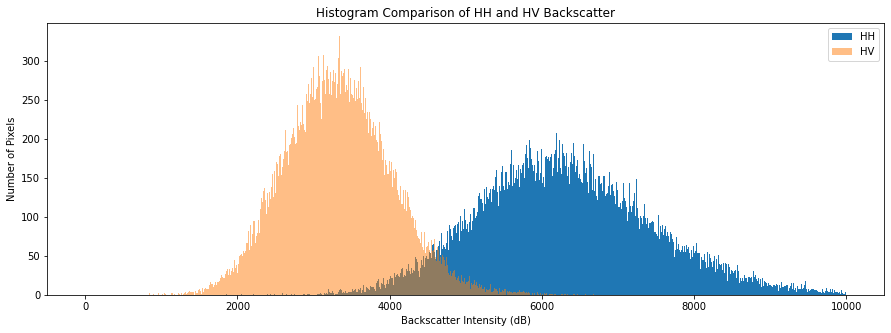

In [ ]:
fig = plt.figure(figsize=(15, 5))
sar_dataset.isel(time=year_index).hh.plot.hist(bins=1000, range=(0,10000), label="HH")
sar_dataset.isel(time=year_index).hv.plot.hist(bins=1000, range=(0,10000), label="HV", alpha=0.5)
plt.legend()
plt.xlabel("Backscatter Intensity (dB)")
plt.ylabel("Number of Pixels")
plt.title("Histogram Comparison of HH and HV Backscatter")
plt.show()

## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in HH and HV image products. 

In [ ]:
# Creation of a new band (HH/HV = hhhv) for RGB display
sar_dataset['hhhv'] = sar_dataset.hh / sar_dataset.hv

In [ ]:
hh = sar_dataset.hh.astype(np.int64); hh_min = hh.min(); hh_max = hh.max()
sar_dataset['hh_amp'] = hh*255/12000
hv = sar_dataset.hv.astype(np.int64); hv_min = hv.min(); hv_max = hv.max()
sar_dataset['hv_amp'] = hv*255/6000
hhhv = sar_dataset.hhhv.astype(np.int64); hhhv_min = hhhv.min(); hhhv_max = hhhv.max()
sar_dataset['hhhv_amp'] = 50*(hh/12000)/(hv/6000)

## HH, HV and RGB images

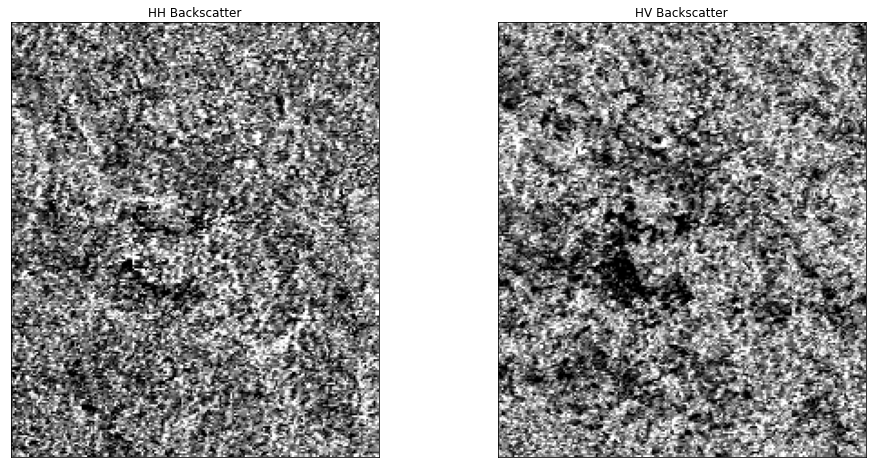

In [ ]:
# Plots of HH and HV Backscatter Intensity
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rgb(sar_dataset.isel(time=year_index), ax=ax[0], bands=['hh_amp','hh_amp','hh_amp'])
rgb(sar_dataset.isel(time=year_index), ax=ax[1], bands=['hv_amp','hv_amp','hv_amp'])
ax[0].set_title('HH Backscatter'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('HV Backscatter'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

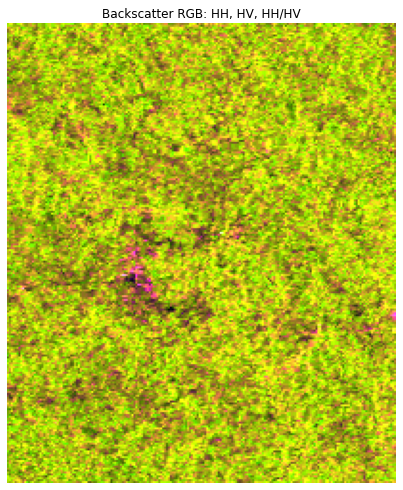

In [ ]:
# RGB Plot of Backscatter Intensity (RGB= HH, HV, HH/HV)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# New vegetation and urban areas are MAGENTA in color (due to high overall scattering and higher HH compared to HV)
# Low vegetation areas are BLUE (due to low overall scattering and higher HH compared to HV)
# Water is BLACK (low backscatter in both bands with similar HH and HV)

rgb(sar_dataset.isel(time=year_index),bands=['hh_amp','hv_amp','hhhv_amp'], width=10)
plt.title('Backscatter RGB: HH, HV, HH/HV')
plt.axis('off')
plt.show()

## Multi-Date RGB Land Change Product

In [ ]:
# Define a custom RGB - This custom RGB allows specific bands and time slices to be assigned to each color
# This custom RGB can be valuable for viewing land changes between two time periods

def custom_rgb(dataset, rgb_to_data_arr_ind_map, **rgb_kwargs):
    rgb_data = {}
    for channel, [data_var, time_ind] in zip(['red', 'green', 'blue'], rgb_to_data_arr_ind_map):
        rgb_data[channel] = dataset[data_var].isel(time=time_ind)
        rgb_data[channel] = rgb_data[channel].drop('time').to_array()
    rgb_data = xr.Dataset(rgb_data).squeeze('variable')
    rgb_kwargs['dataset'] = rgb_data
    rgb(**rgb_kwargs)
    return fig, ax

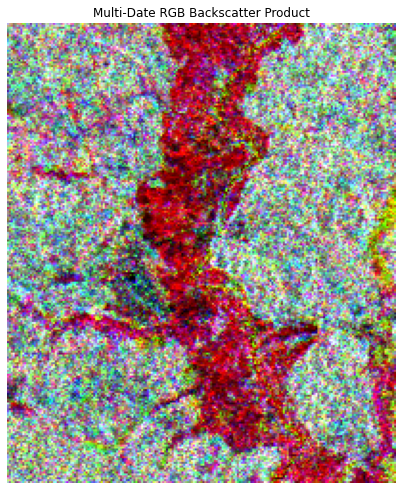

In [ ]:
#3 MODIFY HERE

# Define a custom RGB image using multiple dates and bands
# This product can be useful to view land change between different time periods

# Select the band: 'hh' or 'hv'
band = ['hv']

# Select the scene index for each color: Red, Green, Blue
first_scene = 0   # This is the RED color
second_scene = 5  # This is the GREEN color
third_scene = 9   # This is the BLUE color

# Color Interpretation for output results
# Red areas have high vegetation (cropping) at the early date
# Green areas have high vegetation (cropping) at the middle date
# Blue areas have high vegetation (cropping) at the later date
# Cyan (mix of green and blue) have higher vegetation in 2nd and 3rd dates compared to 1st date
# Magenta (mix of red and blue) have higher vegetation in 1st and 3rd dates compared to 2nd date
# Yellow (mix of red and green) have higher vegetation in 1st and 2nd dates compared to 3rd date
# Grey regions are high scattering (all dates) due to tree foliage or grass vegetation
# Black regions are low scattering (all dates) due to water or low vegetation (bare soils)

rgb_to_data_arr_ind_map = [[band,first_scene],[band,second_scene],[band,third_scene]]
custom_rgb(sar_dataset, rgb_to_data_arr_ind_map, width=10)
plt.title('Multi-Date RGB Backscatter Product')
plt.axis('off')
plt.show()

## Multi-Date Single-Band Threshold Land Change Product
The code below selects two dates, a variable (HH or HV) and a threshold range. The final product performs a comparison of the two dates and calculates the change in backscatter between those dates. Pixels with significant reduction in backscatter (e.g., -1500 dB) are likely due to loss of vegetation and pixels with significant increases in backscatter (e.g., +1500 dB) are likely due to revegetation. 

In [ ]:
#4 MODIFY HERE

# Select TWO acquisitions to calculate a change product
# Choose from the indices in the table above
# first_acq_ind = First time slice acquisition
# second_acq_ind = Second time slice acquisition

first_acq_ind = 0
second_acq_ind = 9

# Select the variable to plot: hh or hv

threshold_variable = 'hv'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range
# GREEN = Pixels MORE than the high end of the threshold range

threshold_range = (-1500, 1500)

In [ ]:
# Set the overlay colors
# Calculate the difference in backscatter between the two times
# Find the pixels above or below the threshold range (these are significant changes)

color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_gain = np.array([0,255,0]) # backscatter increase (GREEN)
color_blue = np.array([0,0,255]) # water (BLUE)

first_acq = sar_dataset.isel(time=first_acq_ind)
second_acq = sar_dataset.isel(time=second_acq_ind)
change_product = second_acq[threshold_variable] - first_acq[threshold_variable]

below_th = change_product.values < threshold_range[0]
above_th = threshold_range[1] < change_product.values

In [ ]:
# Set the water threshold value based on data in the histograms for the selected band
# This will "mask" the water pixels and not show false change
# This value may need adjusting for some areas with low backscatter (bare soils)

water = first_acq[threshold_variable].values < 500

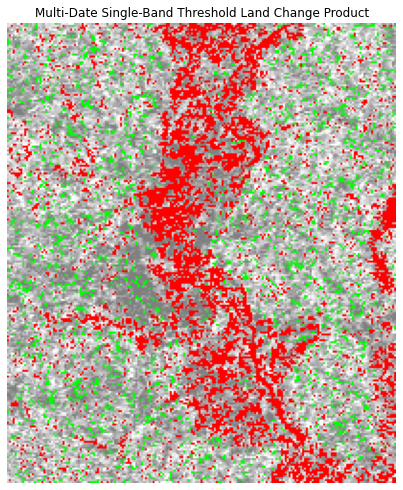

In [ ]:
# Create a custom threshold plot to identify land change
# The background image HH backscatter (grey-scale)
# RED areas have decreased backscatter or a loss of vegetation
# GREEN areas have increased backscatter or an increase in vegetation
# BLUE areas are water in the first image

rgb(first_acq, bands=['hv', 'hv', 'hv'], 
    paint_on_mask=[(below_th, color_loss),(above_th, color_gain),(water, color_blue)], width=10, min_inten=0.5)
plt.title('Multi-Date Single-Band Threshold Land Change Product')
plt.axis('off')
plt.show()

## Display Acquisition Dates 
The acquisition dates for each pixel for a selected mosaic year will be displayed. The ALOS data acquisition plan varies by region but is typically consistent year-to-year within a given region. It is often important to know when data is collected for a mosaic.

In [ ]:
#5 MODIFY HERE

# Select annual mosaic year (use index list) to display pixel-level acquisition dates

year_to_show = 9

In [ ]:
unix_epoch = np.datetime64('1970-01-01')
alos1_epoch, alos2_epoch = np.datetime64('2006-01-24'), np.datetime64('2014-05-24')
pivot = (alos1_epoch - unix_epoch).astype(np.uint16)

def convert_date(date):
    if date == 0:
        return np.datetime64('nat', 'D')
    if date < pivot:
        return date + alos2_epoch
    else:
        return date + unix_epoch

conversion = np.vectorize(convert_date)

Actual Acquisition Dates


,Date
0,2020-06-20


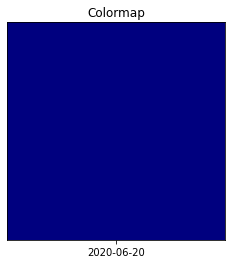

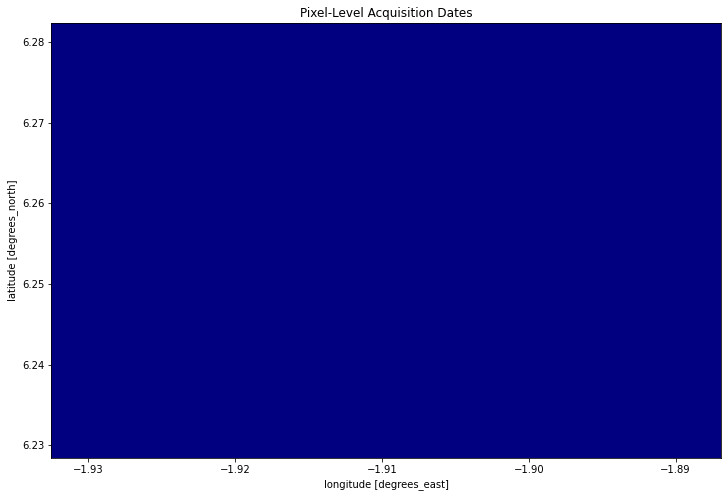

In [ ]:
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=sar_dataset.isel(time=year_to_show).date.min(),
                            vmax=sar_dataset.isel(time=year_to_show).date.max())

m = cm.ScalarMappable(norm=norm, cmap='jet')
fig, ax = plt.subplots(1, 1)

unique_days = sorted(np.unique(sar_dataset.isel(time=year_to_show).date),
                     key=lambda dt: dt.astype(np.uint16))
dates = sorted(conversion(unique_days),
               key=lambda dt: dt.astype(np.uint16))

plt.imshow([m.to_rgba(unique_days)]);
ax.set_xticks(np.arange(len(unique_days)));
ax.set_xticklabels(list(map(lambda x: str(x).split('T')[0], dates)));
ax.set_yticklabels('');
ax.yaxis.set_ticks_position('none');
ax.set_title('Colormap')

fig, ax = plt.subplots(1, 1, figsize=(12,8))
sar_dataset.isel(time=year_to_show).date.plot(norm=norm, cmap='jet', add_colorbar=False);
ax.set_title('Pixel-Level Acquisition Dates');

# Show acquisition dates within region
print("\033[1;4mActual Acquisition Dates\033[0m")
pd.DataFrame(dict(Date=dates))